## AN IMAGE IS WORTH 16X16 WORDS:TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE
https://arxiv.org/pdf/2010.11929.pdf

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12
    assert int(torchvision.__version__.split(".")[1]) >= 13
    print(f"torch version: {torch.__version__}" )
    print(f"torchvision version: {torchvision.__version__}" )
    
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1
torchvision version: 0.15.2


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


try:
    from torchinfo import summary
except:
    !pip3 install -q torchinfo
    from torchinfo import summary
    
import data_setup 
import engine
from helper_functions import download_data, set_seeds, plot_loss_curves

/home/nitiz/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms : {manual_transforms}")

Manually created transforms : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32 #Original Paper has batch size of 4096 but obviously .....

train_dataloader , test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2190a73190>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch , label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape , label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

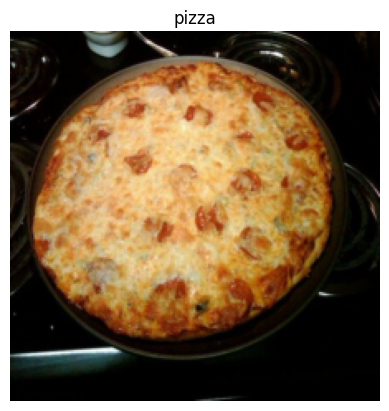

In [9]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [14]:
#examples

height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
print(f"Number of patches(N) with image height (H= {heighht}), width (W = {width}) and patch size (P= {patch_size}) : {number_of_patches}")

Number of patches(N) with image height (H= 224), width (W = 224) and patch size (P= 16) : 196


In [15]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


## Turning a single image into patches


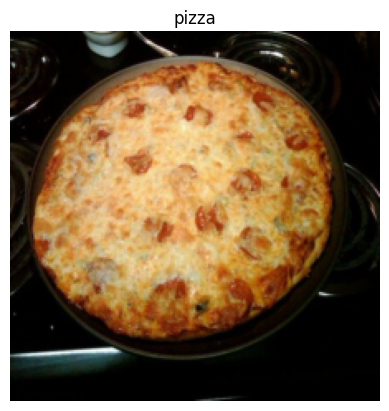

In [16]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

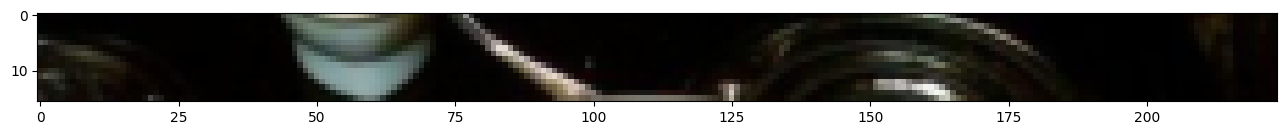

In [21]:
image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row : 14.0
Patch size: 16 pixels x 16 pixels


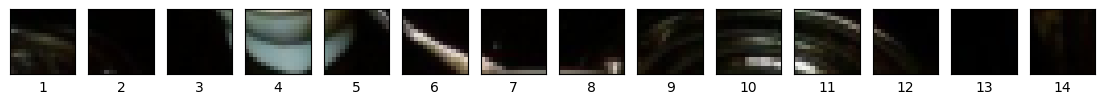

In [23]:
img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row : {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(
    nrows = 1,
    ncols = img_size // patch_size,
    figsize = (num_patches, num_patches),
    sharex = True, 
    sharey = True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch: patch + patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row : 14.0         
Number of patches per column: 14.0         
Total patches: 2744.0         
Patch size: 16 pixels x 16 pixels


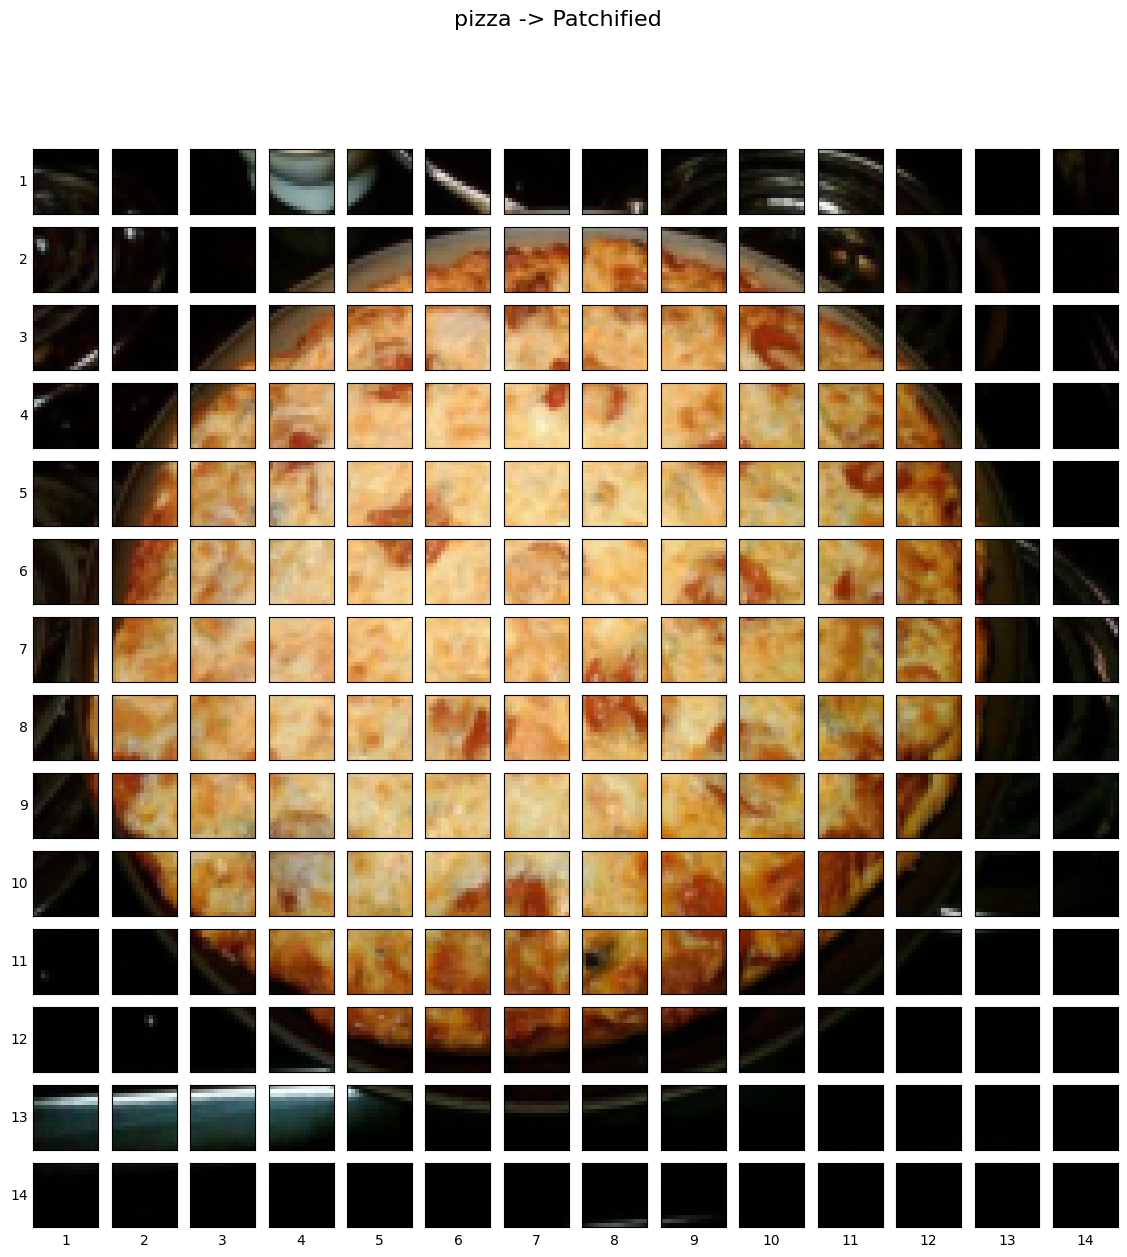

In [27]:
img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row : {num_patches} \
        \nNumber of patches per column: {num_patches} \
        \nTotal patches: {num_patches*number_of_patches} \
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(
    nrows = img_size // patch_size,
    ncols = img_size // patch_size,
    figsize = (num_patches, num_patches),
    sharex = True, 
    sharey = True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size ,
                                      patch_width:patch_width+patch_size,
                                      :])
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

## Creating image patches with torch.nn.Conv2d()

#### 1. Take a single image.
#### 2. Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings).
#### 3. Flatten the 2D feature map into a single sequence.

In [28]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels = 3, #color channels
                   out_channels = 768, # from table 1 for ViT-Base
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

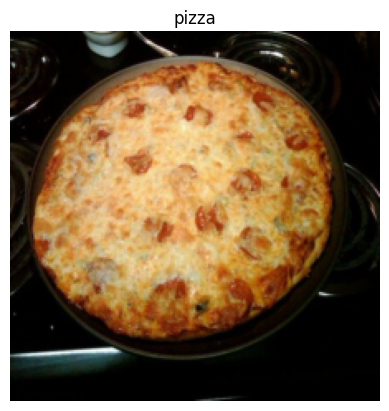

In [29]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [31]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [487, 332, 30, 84, 382]


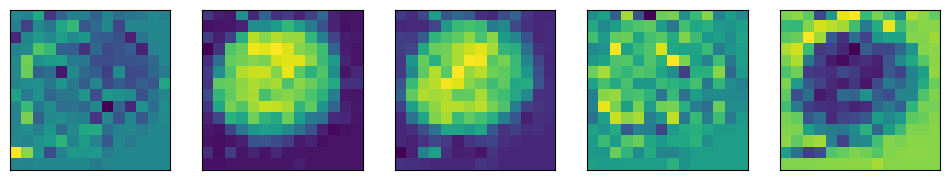

In [33]:
import random
random_indexes = random.sample(range(0, 758) , k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig , axs = plt.subplots(nrows =1 ,ncols = 5, figsize = (12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx,: , :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


In [34]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 6.3437e-02,  1.2400e-02,  2.8193e-03,  2.1140e-01, -1.4016e-03,
           -1.8590e-01, -1.1367e-01, -5.8242e-02, -1.6993e-04, -2.3285e-03,
           -1.1590e-01,  3.3054e-02,  3.4468e-02,  2.0145e-02],
          [ 8.9670e-03, -3.7647e-02,  3.5408e-02, -9.9268e-03,  2.4233e-02,
           -2.6345e-02,  7.8086e-03, -1.3214e-01,  8.7420e-02,  8.1850e-03,
           -7.6774e-02,  8.4527e-03,  3.0217e-02,  3.2195e-02],
          [-4.6215e-02,  4.1648e-02,  3.9478e-02, -6.8074e-02, -3.4440e-03,
            8.2456e-02, -4.3178e-02,  8.4885e-02, -5.0132e-02, -3.5738e-02,
           -3.1419e-03, -2.9205e-02,  2.3552e-02,  3.6808e-02],
          [ 1.1384e-01,  5.4784e-02, -5.4543e-02, -1.0650e-03,  3.6292e-02,
            6.5934e-03, -2.8841e-02,  2.5027e-02, -1.6860e-02,  2.9137e-02,
           -8.4777e-02, -1.9080e-02,  1.4610e-02,  3.6043e-02],
          [ 3.5700e-02,  1.7886e-02,  5.8717e-02,  2.0512e-02,  2.2928e-02,
            7.3462e-02,  5.8084e-02,  6.1372e-02,  2.1553e-0

In [35]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")


Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [36]:
flatten = nn.Flatten(start_dim = 2,
                    end_dim = 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


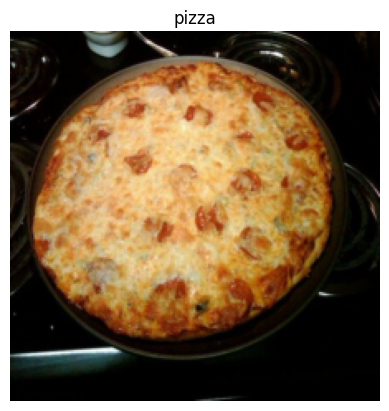

In [37]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [38]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")


Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


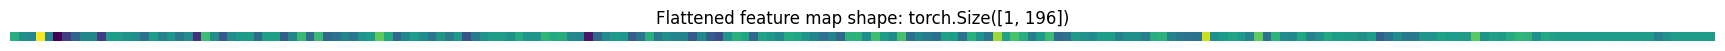

In [39]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [40]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape


(tensor([[ 6.3437e-02,  1.2400e-02,  2.8193e-03,  2.1140e-01, -1.4016e-03,
          -1.8590e-01, -1.1367e-01, -5.8242e-02, -1.6993e-04, -2.3285e-03,
          -1.1590e-01,  3.3054e-02,  3.4468e-02,  2.0145e-02,  8.9670e-03,
          -3.7647e-02,  3.5408e-02, -9.9268e-03,  2.4233e-02, -2.6345e-02,
           7.8086e-03, -1.3214e-01,  8.7420e-02,  8.1850e-03, -7.6774e-02,
           8.4527e-03,  3.0217e-02,  3.2195e-02, -4.6215e-02,  4.1648e-02,
           3.9478e-02, -6.8074e-02, -3.4440e-03,  8.2456e-02, -4.3178e-02,
           8.4885e-02, -5.0132e-02, -3.5738e-02, -3.1419e-03, -2.9205e-02,
           2.3552e-02,  3.6808e-02,  1.1384e-01,  5.4784e-02, -5.4543e-02,
          -1.0650e-03,  3.6292e-02,  6.5934e-03, -2.8841e-02,  2.5027e-02,
          -1.6860e-02,  2.9137e-02, -8.4777e-02, -1.9080e-02,  1.4610e-02,
           3.6043e-02,  3.5700e-02,  1.7886e-02,  5.8717e-02,  2.0512e-02,
           2.2928e-02,  7.3462e-02,  5.8084e-02,  6.1372e-02,  2.1553e-03,
          -2.9975e-04, -1

## Turning the ViT patch embedding layer into a PyTorch module

In [43]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    
    def __init__(self,
                in_channels:int = 3,
                patch_size:int= 16,
                embedding_dim:int = 16):
        
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, 
                                    end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        return x_flattened.permute(0, 2, 1)
        

In [44]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [47]:
random_input_image = (1, 3, 224, 224)
summary(PatchEmbedding(), 
         input_size=random_input_image, 
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 16]         --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 16, 14, 14]      12,304               True
├─Flatten (flatten)                      [1, 16, 14, 14]      [1, 16, 196]         --                   --
Total params: 12,304
Trainable params: 12,304
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.41
Input size (MB): 0.60
Forward/backward pass size (MB): 0.03
Params size (MB): 0.05
Estimated Total Size (MB): 0.68

##  Creating the class token embedding

In [48]:
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.1290, -0.0293, -0.0711,  ...,  0.0299, -0.0079,  0.0023],
         [-0.0354, -0.0187, -0.0456,  ...,  0.0090,  0.0034,  0.0210],
         [-0.0519,  0.1249, -0.0377,  ...,  0.0019, -0.0861,  0.0157],
         ...,
         [-0.0197, -0.0121, -0.0319,  ...,  0.0124, -0.0052,  0.0029],
         [-0.0184, -0.0117, -0.0316,  ...,  0.0106, -0.0043,  0.0036],
         [-0.0199, -0.0117, -0.0302,  ...,  0.0106, -0.0038,  0.0037]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [49]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True)

print(class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [52]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1)
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1290, -0.0293, -0.0711,  ...,  0.0299, -0.0079,  0.0023],
         [-0.0354, -0.0187, -0.0456,  ...,  0.0090,  0.0034,  0.0210],
         ...,
         [-0.0197, -0.0121, -0.0319,  ...,  0.0124, -0.0052,  0.0029],
         [-0.0184, -0.0117, -0.0316,  ...,  0.0106, -0.0043,  0.0036],
         [-0.0199, -0.0117, -0.0302,  ...,  0.0106, -0.0038,  0.0037]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Creating the position embedding

In [53]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape


(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1290, -0.0293, -0.0711,  ...,  0.0299, -0.0079,  0.0023],
          [-0.0354, -0.0187, -0.0456,  ...,  0.0090,  0.0034,  0.0210],
          ...,
          [-0.0197, -0.0121, -0.0319,  ...,  0.0124, -0.0052,  0.0029],
          [-0.0184, -0.0117, -0.0316,  ...,  0.0106, -0.0043,  0.0036],
          [-0.0199, -0.0117, -0.0302,  ...,  0.0106, -0.0038,  0.0037]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [54]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                             requires_grad = True)

print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [55]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8710, 0.9707, 0.9289,  ..., 1.0299, 0.9921, 1.0023],
         [0.9646, 0.9813, 0.9544,  ..., 1.0090, 1.0034, 1.0210],
         ...,
         [0.9803, 0.9879, 0.9681,  ..., 1.0124, 0.9948, 1.0029],
         [0.9816, 0.9883, 0.9684,  ..., 1.0106, 0.9957, 1.0036],
         [0.9801, 0.9883, 0.9698,  ..., 1.0106, 0.9962, 1.0037]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Putting it all together: from image to embedding

In [56]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                      patch_size= patch_size,
                                      embedding_dim = 768)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) 
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
